In [1]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import pickle
import numpy as np
import training
import config
import matplotlib.pyplot as plt
import FigureConfig as FC

In [2]:
a = torch.load('./data/hard_sigmoid_power.ds')

In [3]:
X, Y = a['X'], a['Y']
Xn, Yn = a['Xn'], a['Yn']
X_min, X_max = a['X_min'], a['X_max']
Y_min, Y_max = a['Y_min'], a['Y_max']

X_learn, Y_learn = a['X_learn'], a['Y_learn']
X_train, Y_train = a['X_train'], a['Y_train']
X_valid, Y_valid = a['X_valid'], a['Y_valid']
X_test , Y_test  = a['X_test'] , a['Y_test']

Xn_learn, Yn_learn = a['Xn_learn'], a['Yn_learn']
Xn_train, Yn_train = a['Xn_train'], a['Yn_train']
Xn_valid, Yn_valid = a['Xn_valid'], a['Yn_valid']
Xn_test , Yn_test  = a['Xn_test'] , a['Yn_test']

In [4]:
train_data = TensorDataset(Xn_train, Yn_train)
valid_data  = TensorDataset(Xn_valid, Yn_valid)
test_data  = TensorDataset(Xn_test, Yn_test)

train_loader = DataLoader(train_data, batch_size=len(train_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))

In [5]:
SEEDs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
layer = 10
lr = -5

In [6]:
lossfunction = torch.nn.MSELoss()

In [7]:
results = torch.zeros([10, 3])

Sequential(
  (0-MAC): Linear(in_features=4, out_features=3, bias=True)
  (0-ACT): PReLU(num_parameters=1)
  (1-MAC): Linear(in_features=3, out_features=3, bias=True)
  (1-ACT): PReLU(num_parameters=1)
  (2-MAC): Linear(in_features=3, out_features=3, bias=True)
  (2-ACT): PReLU(num_parameters=1)
  (3-MAC): Linear(in_features=3, out_features=2, bias=True)
  (3-ACT): PReLU(num_parameters=1)
  (4-MAC): Linear(in_features=2, out_features=2, bias=True)
  (4-ACT): PReLU(num_parameters=1)
  (5-MAC): Linear(in_features=2, out_features=2, bias=True)
  (5-ACT): PReLU(num_parameters=1)
  (6-MAC): Linear(in_features=2, out_features=1, bias=True)
  (6-ACT): PReLU(num_parameters=1)
  (7-MAC): Linear(in_features=1, out_features=1, bias=True)
  (7-ACT): PReLU(num_parameters=1)
  (8-MAC): Linear(in_features=1, out_features=1, bias=True)
  (8-ACT): PReLU(num_parameters=1)
)
Sequential(
  (0-MAC): Linear(in_features=4, out_features=3, bias=True)
  (0-ACT): PReLU(num_parameters=1)
  (1-MAC): Linear(in_fea

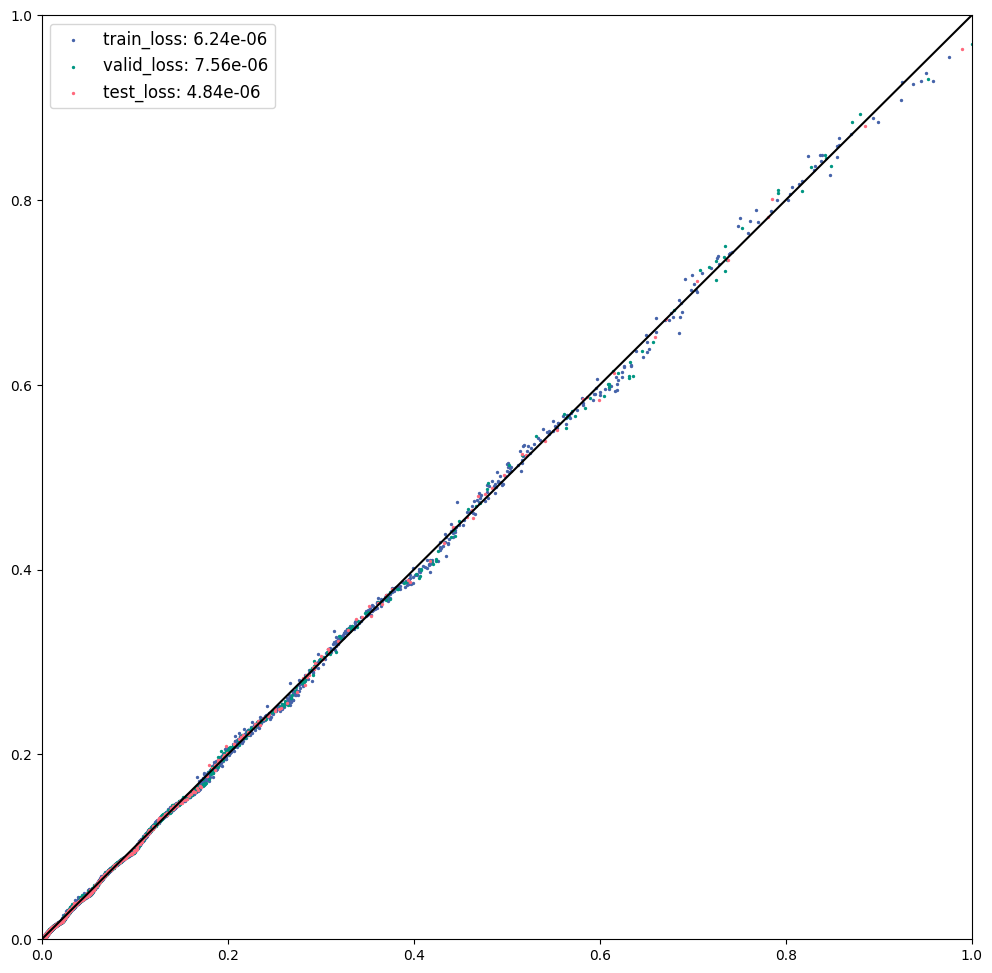

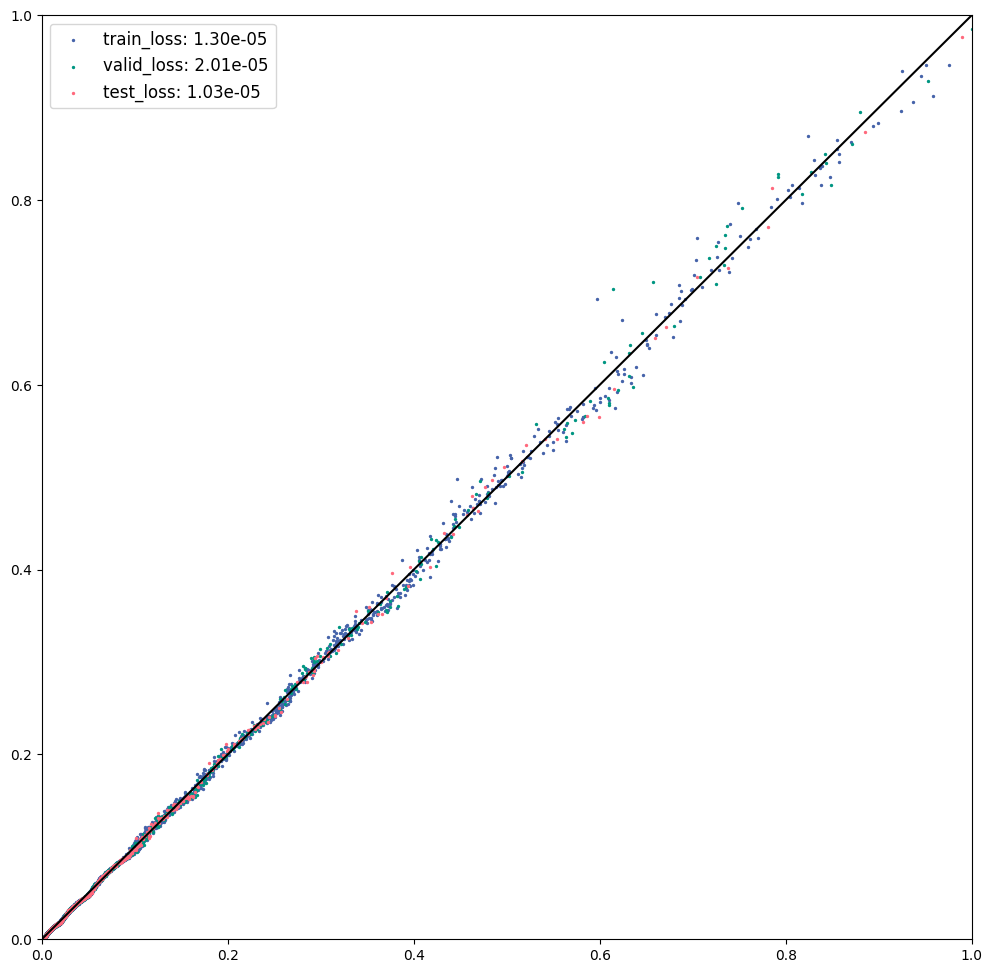

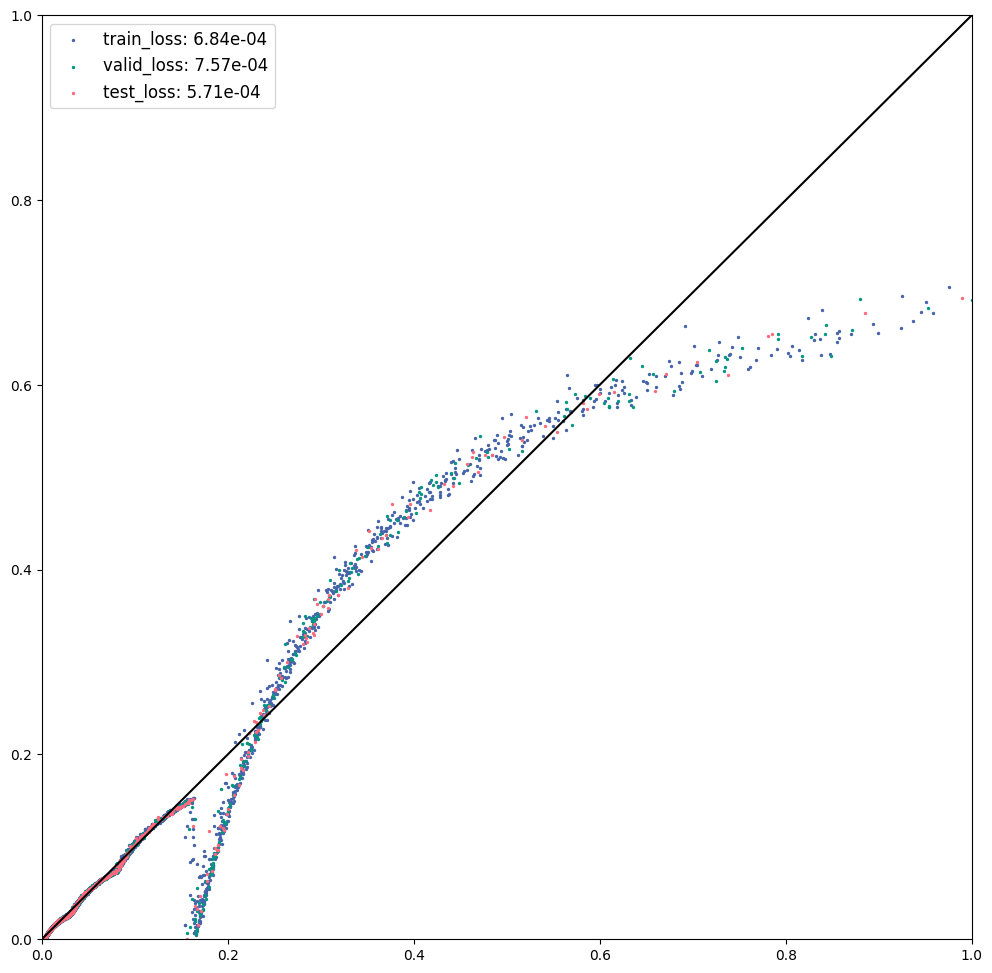

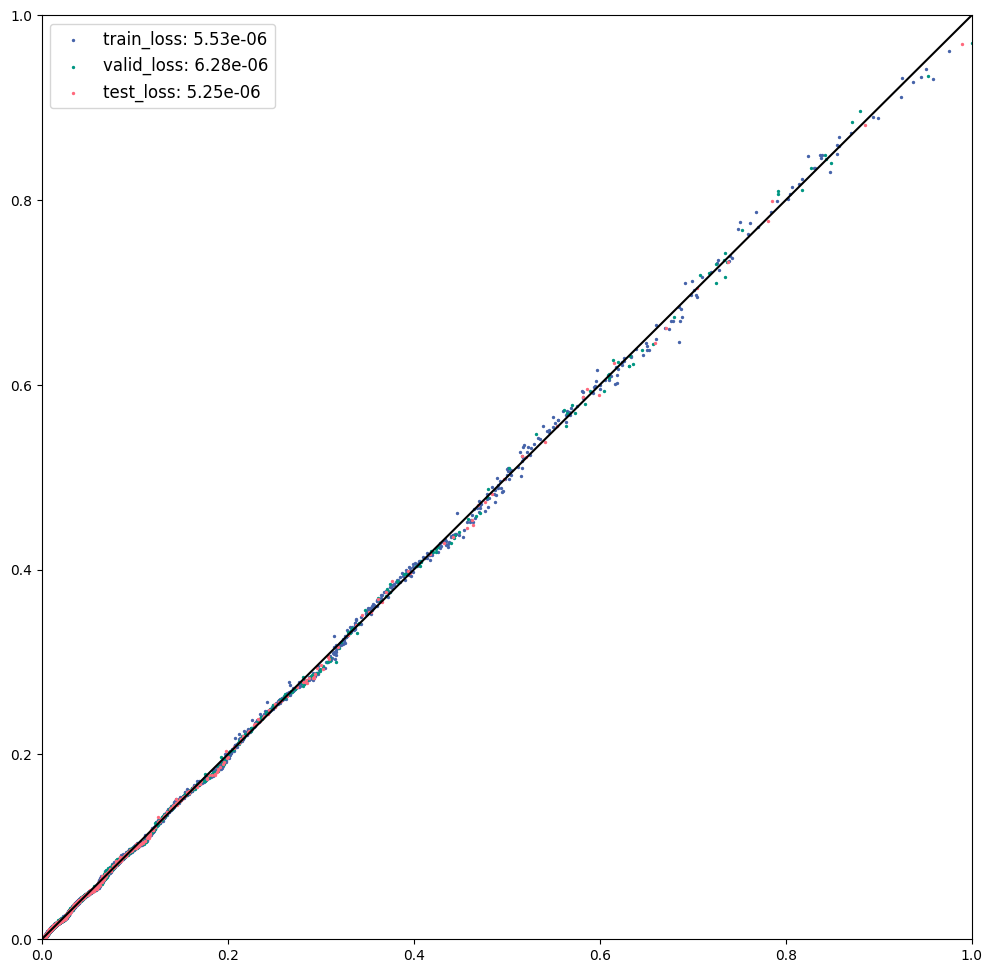

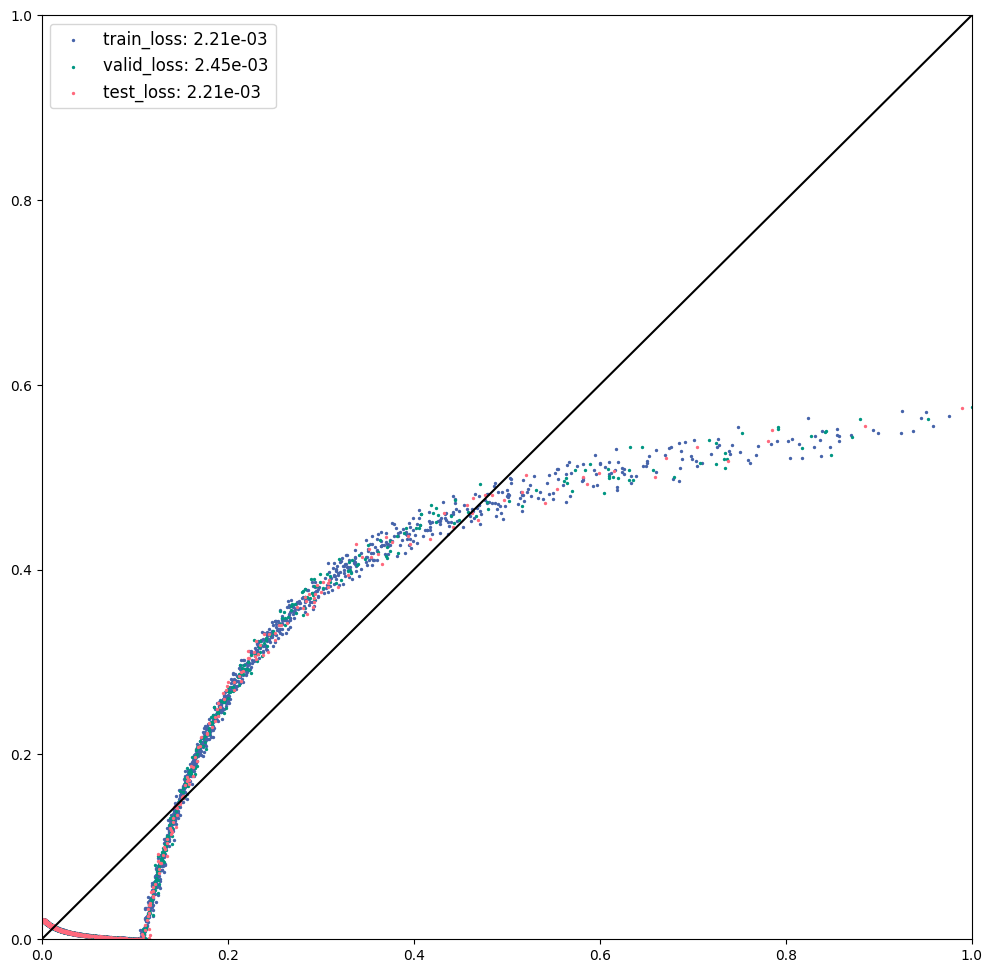

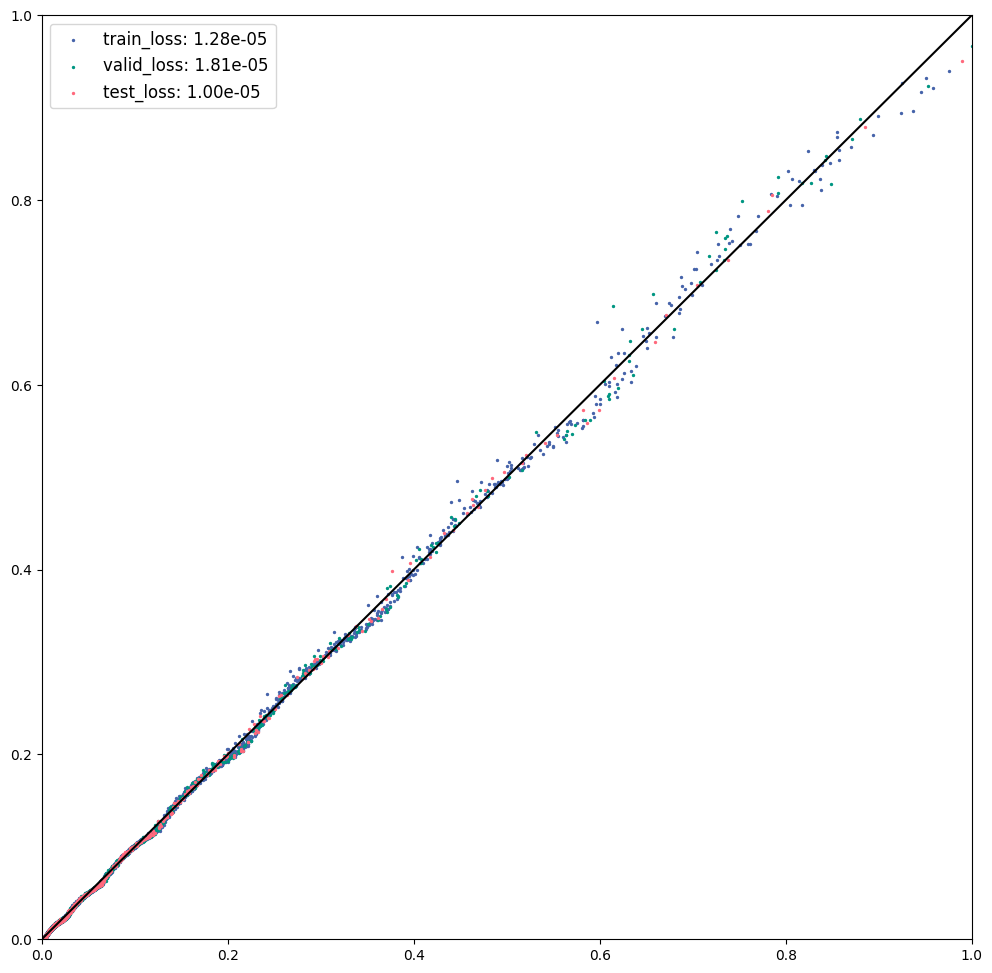

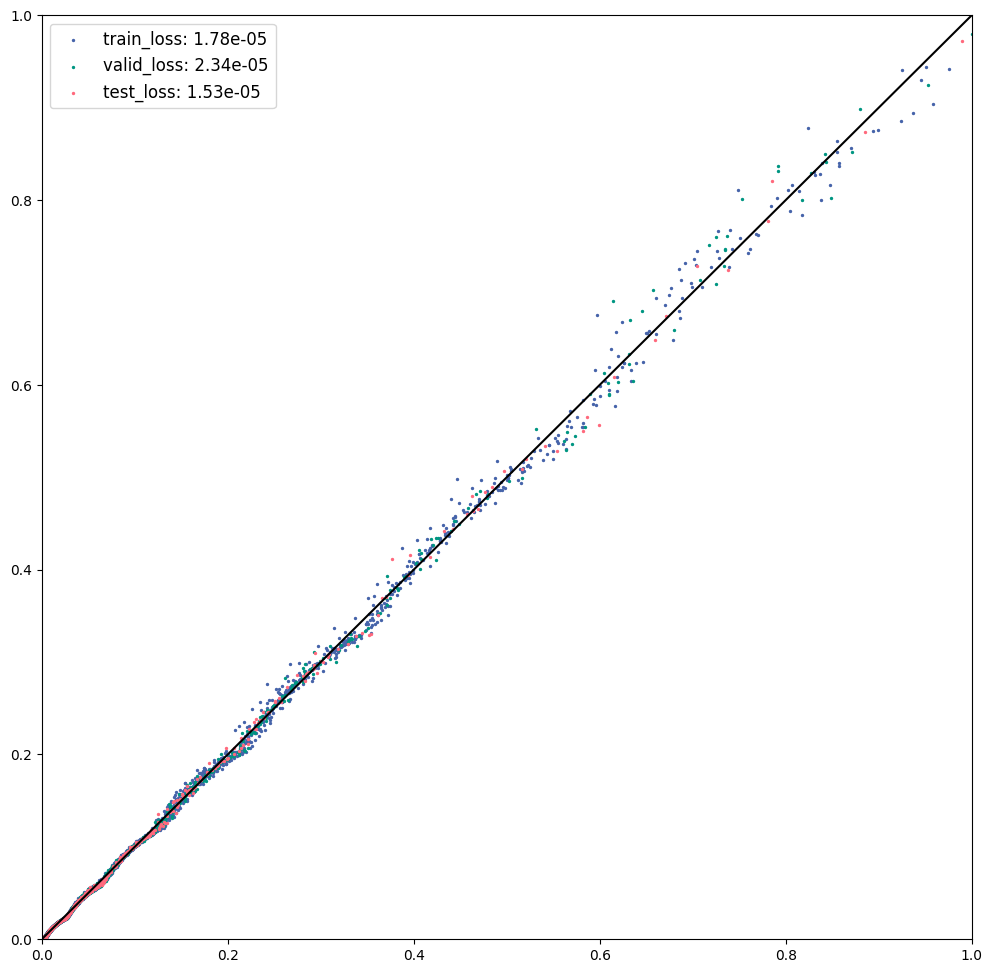

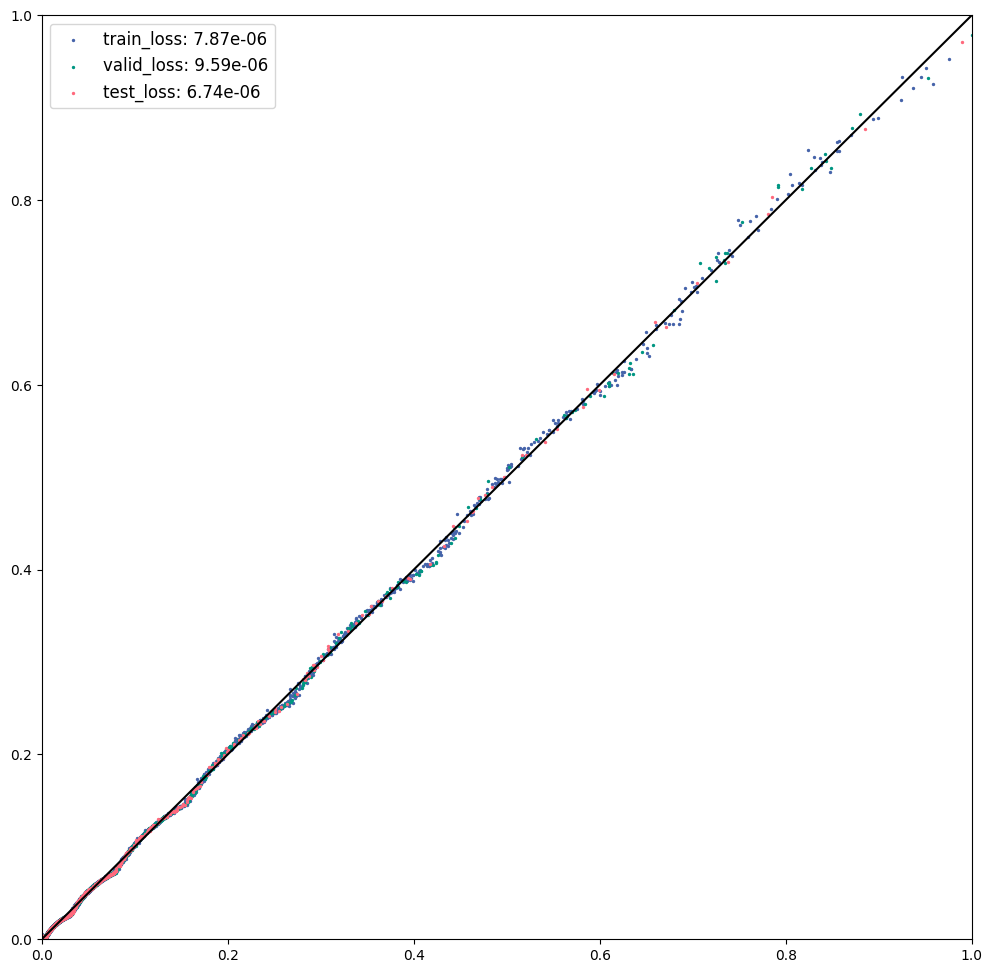

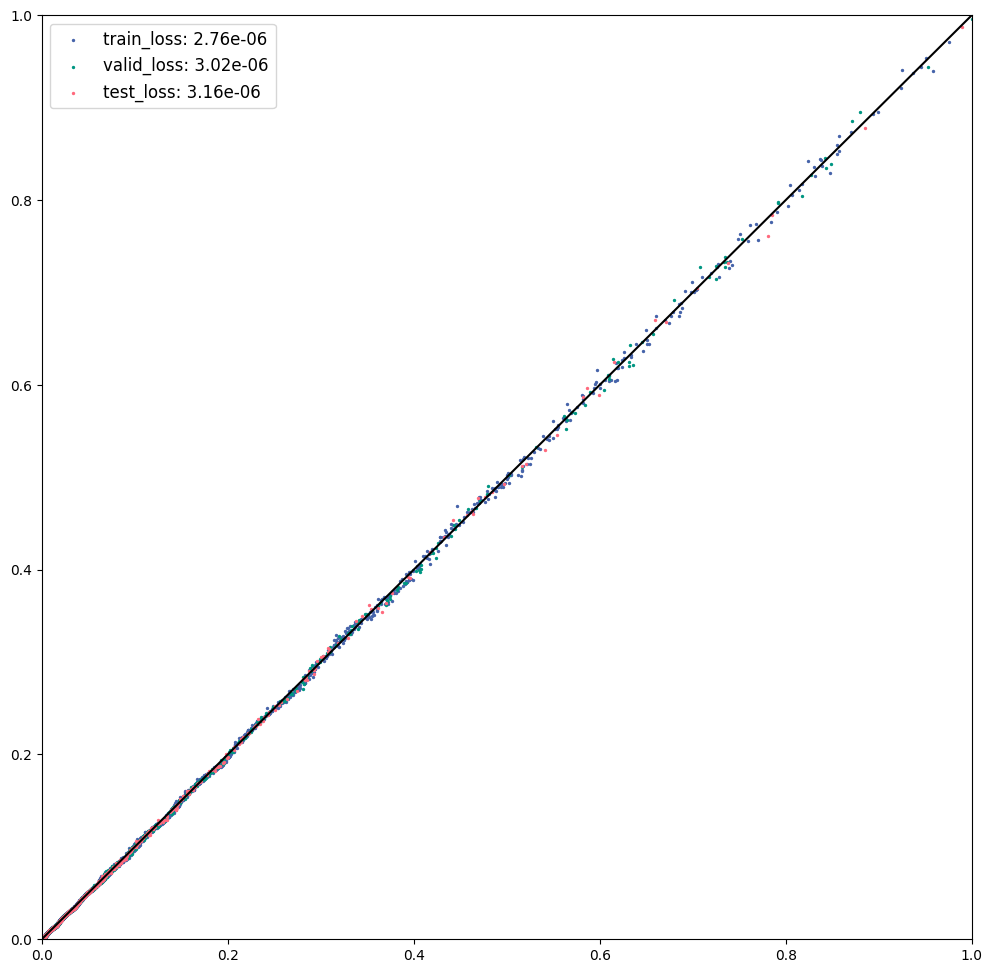

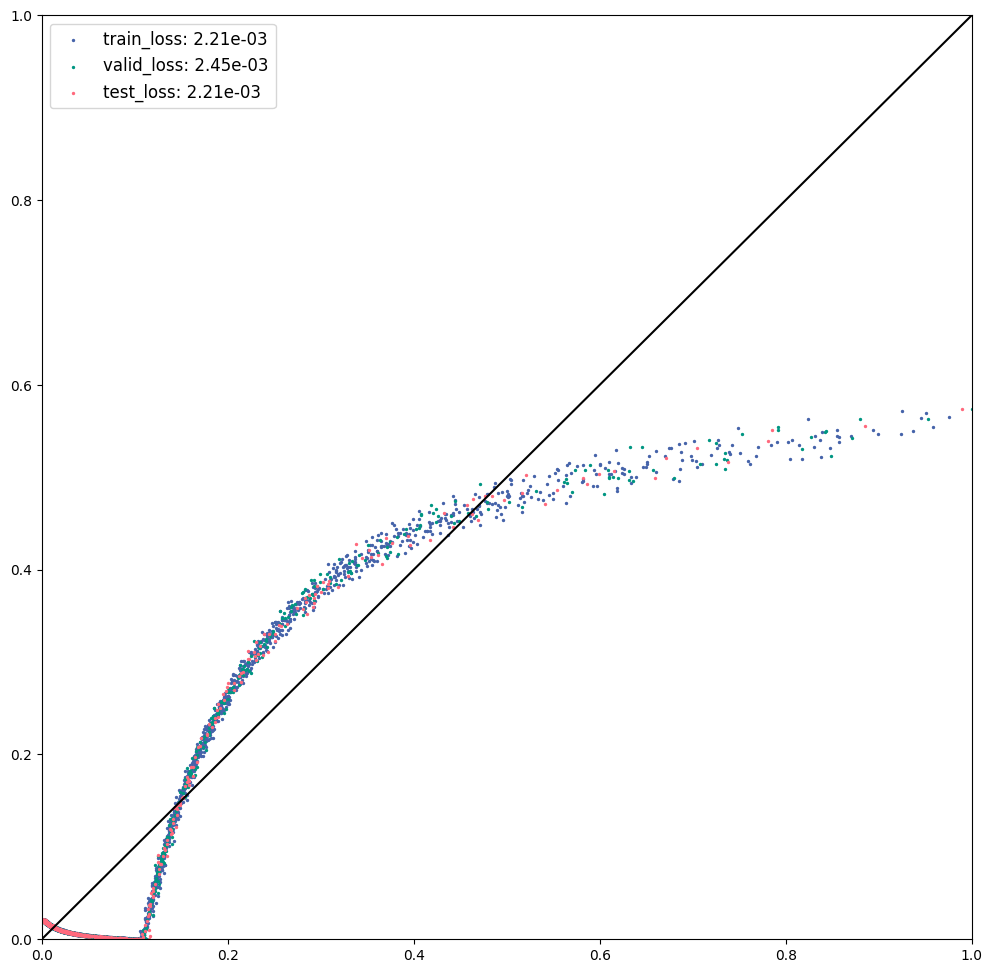

In [8]:
for s, seed in enumerate(SEEDs):

    exp_setup = f'{layer}_{lr}_{seed}'

    NN_temp = torch.load(f'./NNs/HSP_{exp_setup}.model')
    print(NN_temp)
    for x_train, y_train in train_loader:
        prediction_train = NN_temp(x_train)
    for x_valid, y_valid in valid_loader:
        prediction_valid = NN_temp(x_valid)
    for x_test, y_test in test_loader:
        prediction_test = NN_temp(x_test)

    loss_train = lossfunction(Yn_train, prediction_train)
    loss_valid = lossfunction(Yn_valid, prediction_valid)
    loss_test  = lossfunction(Yn_test,  prediction_test)

    results[s, 0] = loss_train
    results[s, 1] = loss_valid
    results[s, 2] = loss_test

    plt.figure(figsize=(12,12))
    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100),  c='black')
    plt.scatter(Yn_train.flatten().numpy(), prediction_train.detach().flatten().numpy(), s=2, color=FC.Blue, label=f'train_loss: {loss_train:.2e}')
    plt.scatter(Yn_valid.flatten().numpy(), prediction_valid.detach().flatten().numpy(), s=2, color=FC.Green, label=f'valid_loss: {loss_valid:.2e}')
    plt.scatter(Yn_test.flatten().numpy(), prediction_test.detach().flatten().numpy(), s=2, color=FC.Pink, label=f'test_loss: {loss_test:.2e}')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(fontsize=12)
    plt.savefig(f'./NNs/final_HSP_{exp_setup}.pdf', format='pdf', bbox_inches='tight', transparent=True)

# Best model

In [9]:
torch.where(results == results[:,1].min())[0]

tensor([8])

# Save model for further use

In [10]:
exp_setup = f'{layer}_{lr}_{SEEDs[int(torch.where(results == results[:,1].min())[0])]}'

In [11]:
final_HSP = torch.load(f'./NNs/HSP_{exp_setup}.model')
package = {'eta_estimator': final_HSP,
           'X_min': X_min, 'X_max': X_max,
           'Y_min': Y_min, 'Y_max': Y_max}
torch.save(package, '../hard_sigmoid_power.package')